## Reproducibility when testing

In [88]:
# see https://pytorch.org/docs/stable/notes/randomness.html
# torch.manual_seed(0)

# when using cuda
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Getting Data

In [2]:
import os
from pathlib import Path
import scipy.io  # for reading matlab matrix
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

In [101]:
# custom DataSet class
class ParametrizedShirtDataSet(Dataset):
    """
    For loading the data of "Learning Shared Shape Space.." paper
    """
    
    def __init__(self, root_dir, transform = None):
        """
        Args:
            root_dir (string): Directory with all the t-shirt examples as subfolders
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.root_path = Path(root_dir)
        
        # list of items = subfolders
        self.datapoints_names = next(os.walk(self.root_path))[1]
        
        # datapoint folder structure
        self.mesh_filename = 'shirt_mesh_r.obj'
        self.pattern_params_filename = 'shirt_info.txt'
        self.pca_filename = 'visfea.mat'
        
    def update_transform(self, transform):
        """apply new transform when loading the data"""
        self.transform = transform
        
    def __len__(self):
        """Number of entries in the dataset"""
        return len(self.datapoints_names)
    
    
    def read_pca(self, datapoint_name):
        """pca parameters from a given datapoint subfolder"""
        assert (self.root_path / datapoint_name / self.pca_filename).exists()
        
        matlab_mat = scipy.io.loadmat(self.root_path / datapoint_name / self.pca_filename)
        # assuming fea1 is what we need
        return np.asarray(matlab_mat['fea2']).squeeze()
    
    
    def read_pattern_params(self, datapoint_name):
        """9 pattern size parameters from a given datapoint subfolder"""
        assert (self.root_path / datapoint_name / self.pattern_params_filename).exists()
        
        # assuming that we need the numbers from the last line in file
        with open(self.root_path / datapoint_name / self.pattern_params_filename) as f:
            lines = f.readlines()
            params = np.fromstring(lines[-1],  sep = ' ')
        return params
        
    
    def __getitem__(self, idx):
        """Called when indexing: read the corresponding data. 
        Does not support list indexing"""
        
        if torch.is_tensor(idx):  # allow indexing by tensors
            idx = idx.tolist()
            
        datapoint_name = self.datapoints_names[idx]
        
        pca = self.read_pca(datapoint_name)
        
        # read the pattern parameters
        pattern_parameters = self.read_pattern_params(datapoint_name)
        
        sample = {'pca' : pca, 'pattern_params' : pattern_parameters}
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample
        

In [5]:
# Custom transforms -- to tensor
class SampleToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        pca, params = sample['pca'], sample['pattern_params']
        
        return {'pca': torch.from_numpy(pca).float(), 'pattern_params': torch.from_numpy(params).float()}

In [70]:
# Custom transforms -- normalize
class NormalizeInputPCA(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, mean_pca, std_pca):
        self.mean = mean_pca
        self.std = std_pca
    
    def __call__(self, sample):
        pca, params = sample['pca'], sample['pattern_params']
        
        return {'pca': torch.div((pca - self.mean), self.std), 'pattern_params': params}

In [88]:
# Data Normalization?

def get_mean_std(dataloader):
    
    stats = { 'batch_sums' : [], 'batch_sq_sums' : []}
    
    for data in dataloader:
        batch_sum = data['pca'].sum(0)
        stats['batch_sums'].append(batch_sum)

    mean_pca = sum(stats['batch_sums']) / len(dataloader)
    
    for data in dataloader:
        batch_sum_sq = (data['pca'] - mean_pca.view(1, len(mean_pca)))**2
        stats['batch_sq_sums'].append(batch_sum_sq.sum(0))
                        
    std_pca = torch.sqrt(sum(stats['batch_sq_sums']) / len(dataloader))
    
    return mean_pca, std_pca
    

In [92]:
# test loading
dataset = ParametrizedShirtDataSet(Path('F:\Learning Shared Shape Space_shirt_dataset_rest'), 
                                  SampleToTensor())

print (len(dataset))
print (dataset[1000]['pca'].shape)
print (dataset[1000]['pattern_params'].shape)
#print (dataset[1000])

loader = DataLoader(dataset, 10, shuffle=True)

mean, std = get_mean_std(loader)
print (mean, std)


1050
torch.Size([100])
torch.Size([9])
tensor([22.3122, 80.2369, 94.7878, 84.7305, 87.0633, 94.7269, 87.1609, 68.4383,
        54.0221, 42.9530, 36.4926, 34.2573, 36.1983, 39.6058, 42.5963, 45.8251,
        49.0148, 51.9638, 54.5384, 56.2717, 57.3045, 59.2304, 60.3443, 60.7170,
        60.3732, 61.0602, 61.7098, 61.3839, 61.6671, 61.5640, 61.4332, 60.3661,
        58.6125, 56.2172, 53.0113, 49.2049, 44.8146, 39.5825, 34.9495, 30.5814,
        27.0672, 23.1549, 20.1863, 18.3758, 17.5469, 17.5358, 17.2857, 17.4499,
        17.6876, 18.2172, 18.5054, 18.3967, 18.6611, 18.9819, 18.8736, 18.9814,
        18.6072, 18.4159, 18.4734, 18.9060, 18.9909, 19.0221, 19.1951, 19.2275,
        19.2909, 19.3687, 19.2872, 19.1948, 19.3135, 19.4129, 19.3294, 19.1605,
        19.0412, 19.0545, 18.9051, 18.6651, 18.6090, 18.4858, 18.4188, 18.1001,
        17.7318, 17.6019, 17.6670, 17.5875, 17.6099, 17.4483, 17.4991, 17.7228,
        17.8360, 17.9263, 18.0252, 18.2533, 18.7004, 18.9687, 19.3407, 21.3461,
 

In [93]:
dataset_normalized = ParametrizedShirtDataSet(Path('F:\Learning Shared Shape Space_shirt_dataset_rest'), 
                                  transforms.Compose([
                                      SampleToTensor(), 
                                      NormalizeInputPCA(mean, std)]))

print (dataset[1]['pca'])
print (dataset_normalized[1]['pca'])

tensor([ 1.7280, 10.0000, 10.0000,  5.7167, 10.0000, 10.0000, 10.0000,  1.7942,
         2.7499,  3.4947,  4.5604,  1.3809,  1.3401,  1.9693,  2.7231,  4.4794,
         5.4335,  4.9750,  6.6098,  7.1386,  6.5891,  6.2242,  5.0481,  6.1127,
         6.0178,  5.3848,  6.3810,  5.7453,  5.3307,  3.7287,  8.7910,  9.0789,
         9.1678, 10.0000, 10.0000,  2.4115,  0.9612,  1.1466,  1.1053,  1.0611,
         1.0211,  1.0210,  0.9864,  0.9422,  2.7900,  2.8249,  1.4483,  1.8033,
         1.1050,  0.9412,  1.0041,  0.9973,  0.9732,  0.9511,  0.9558,  1.0157,
         1.0167,  0.9513,  0.9543,  1.2004,  1.3300,  0.9807,  0.9578,  0.9972,
         1.0205,  0.9093,  0.9328,  0.9820,  0.9938,  0.9847,  1.0011,  1.0261,
         0.9751,  1.0542,  1.0290,  1.0384,  1.0466,  1.0319,  1.0156,  1.0526,
         1.1265,  1.2638,  1.1140,  1.1654,  1.0753,  1.1316,  1.0372,  1.0565,
         1.0130,  1.0182,  0.9955,  1.0444,  1.0865,  1.2461,  1.3008,  1.6466,
         2.9357,  7.3296, 10.0000, 10.00

# Defining a Net

In [8]:
import torch.nn as nn
import torch.functional as F

In [9]:
class ShirtPCAMLP(nn.Module):
    """MLP for training on shirts dataset. Assumes 100 PCA parameters used"""
    
    def __init__(self):
        super().__init__()
        
        # layers definitions
        self.sequence = nn.Sequential(
            nn.Linear(100, 120), 
            nn.ReLU(), 
            nn.Linear(120, 80), 
            nn.ReLU(), 
            nn.Linear(80, 60),
            nn.ReLU(),
            nn.Linear(60, 9)
        )
    
    def forward(self, x_batch):
        return self.sequence(x_batch)

In [10]:
net = ShirtPCAMLP()

print (net)

ShirtPCAMLP(
  (sequence): Sequential(
    (0): Linear(in_features=100, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=80, bias=True)
    (3): ReLU()
    (4): Linear(in_features=80, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=9, bias=True)
  )
)


# Training

## Setup

In [13]:
# Basic Parameters
batch_size = 64
epochs_num = 100
learning_rate = 0.1

In [102]:
# Data normalization
shirt_dataset = ParametrizedShirtDataSet(Path('F:\Learning Shared Shape Space_shirt_dataset_rest'), 
                                  SampleToTensor())

mean, std = get_mean_std(DataLoader(shirt_dataset, 100))


In [103]:
# Data load and split
shirt_dataset_normalized = ParametrizedShirtDataSet(Path('F:\Learning Shared Shape Space_shirt_dataset_rest'), 
                                  transforms.Compose([
                                      SampleToTensor(), 
                                      NormalizeInputPCA(mean, std)]))

valid_size = (int) (len(shirt_dataset_normalized) / 10)
# split is RANDOM. Might affect performance
training_set, validation_set = torch.utils.data.random_split(
    shirt_dataset_normalized, 
    (len(shirt_dataset) - valid_size, valid_size))

print ('Split: {} / {}'.format(len(training_set), len(validation_set)))

training_loader = DataLoader(training_set, batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size)

Split: 945 / 105


## Training loop

In [36]:
# Training loop func

def fit(model, regression_loss, optimizer, train_loader):
    
    validation_losses = []
    running_losses = []
    
    for epoch in range (epochs_num):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(training_loader):
            preds = model(batch['pca'])
            
            loss = regression_loss(preds, batch['pattern_params'])
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            
            # logging
            running_loss += loss.item()
            if i % 5 == 4:
                wb.log({'epoch': epoch, 'loss': loss})
            
        running_losses.append(running_loss / (len(training_loader)))
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[(regression_loss(model(batch['pca']), batch['pattern_params']), len(batch)) for batch in validation_loader]
            )
            
        valid_loss = np.sum(losses) / np.sum(nums)
        validation_losses.append(valid_loss)
        print ('Epoch: {}, Validation Loss: {}'.format(epoch, valid_loss))
        wb.log({'epoch': epoch, 'valid_loss': valid_loss})
        
    return validation_losses, running_losses

In [104]:
# Get all the definitions
# model
model = ShirtPCAMLP()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# loss function
regression_loss = nn.MSELoss()

In [105]:
# init Weights&biases run
import wandb as wb
wb.init(name = "fea2 + data normalization", project = 'Test-Garments-Reconstruction')

wb.watch(model, log='all')

In [107]:
# train

validation_losses, running_losses = fit(model, regression_loss, optimizer, training_loader)

print ("Finished training")

Epoch: 0, Validation Loss: 0.2201310098171234
Epoch: 1, Validation Loss: 0.023226015269756317
Epoch: 2, Validation Loss: 0.0065571703016757965
Epoch: 3, Validation Loss: 0.0063787889666855335
Epoch: 4, Validation Loss: 0.0063648647628724575
Epoch: 5, Validation Loss: 0.006375469733029604
Epoch: 6, Validation Loss: 0.0063785770907998085
Epoch: 7, Validation Loss: 0.006376917473971844
Epoch: 8, Validation Loss: 0.00639696978032589
Epoch: 9, Validation Loss: 0.006376719102263451
Epoch: 10, Validation Loss: 0.006384765263646841
Epoch: 11, Validation Loss: 0.006378420162945986
Epoch: 12, Validation Loss: 0.00637360755354166
Epoch: 13, Validation Loss: 0.00637438939884305
Epoch: 14, Validation Loss: 0.006384357810020447
Epoch: 15, Validation Loss: 0.006370194256305695
Epoch: 16, Validation Loss: 0.006389564834535122
Epoch: 17, Validation Loss: 0.006381616462022066
Epoch: 18, Validation Loss: 0.0063844723626971245
Epoch: 19, Validation Loss: 0.0063771880231797695
Epoch: 20, Validation Loss: 0

# Visualization

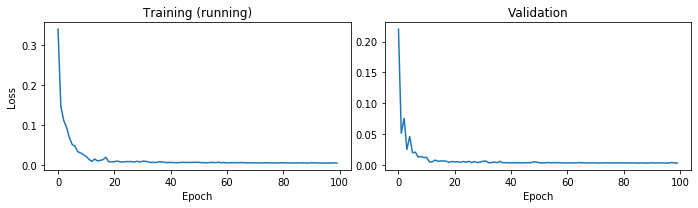

In [32]:
# visuaize losses
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 3))

ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title("Training (running)")
plt.plot(running_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title("Validation")
plt.plot(validation_losses)
plt.xlabel('Epoch')

plt.show()


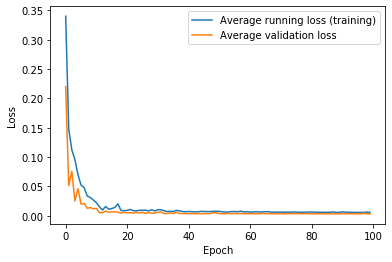

In [33]:
# on the same plot
plt.plot(running_losses, label = "Average running loss (training)")
plt.plot(validation_losses, label = "Average validation loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [210]:
# loss on validation set
valid_loss = sum([regression_loss(model(batch['pca']), batch['pattern_params']) for batch in validation_loader]) 

print ('Validation loss: {}'.format(valid_loss))

Validation loss: 0.011753877624869347
